In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
import ssl
import gensim
import pandas as pd
import math
import pickle
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from gensim.models import KeyedVectors
import spacy
from gensim.models import Word2Vec

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fagnercandido/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/fagnercandido/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import dash
from dash.dependencies import Input, Output, State
from dash import html
from dash import dcc
from jupyter_dash import JupyterDash
from dash import Dash, html, dcc
import flask

In [3]:
def get_eligible_files():
    elegible_files = []
    for file in os.listdir('reuters21578'):
        if file.endswith('.sgm'):
            elegible_files.append(file)
    return elegible_files

def get_documents():
    documents = []
    files = get_eligible_files()
    for file in files:
        content = ''
        try:
            content = open(f'reuters21578/{file}', 'r', encoding="utf-8").read()
        except UnicodeDecodeError as e:
            lines = []
            for line in open(f'reuters21578/{file}', 'rb').readlines():
                line = line.decode('utf-8','ignore') #.encode("utf-8")
                lines.append(line)
            content = '\n'.join(lines)
        soup_document = BeautifulSoup(content.lower(), 'html.parser')
        for document in soup_document.findAll('reuters'):
            documents.append(document)
    return documents

def get_documents_by_dictionary_article():
    articles = {}
    for article in get_documents():
        new_id = article.get('newid')
        date_article = find_element_by_name(article, 'date')
        topics = find_element_by_name(article, 'topics')
        places = find_element_by_name(article, 'places')
        people = find_element_by_name(article, 'people')
        title = find_element_by_name(article, 'title')
        dateline = find_element_by_name(article, 'dateline')
        body = find_element_by_name(article, 'body')
        metadados_article = {}
        for item in ['date_article', 'dateline', 'topics', 'places', 'people', 'title', 'body']:
            metadados_article[item] = eval(item)
        articles[new_id] = metadados_article
    return articles

def find_element_by_name(article, tag):
    element = article.find_all(tag)
    if element:
        return next((x.text for x in element))
    else:
        return ''
    
def preprocess_tokenize_and_lemmatize_and_add_frequency_matrix():
    articles = get_documents_by_dictionary_article()
    for item, value in articles.items():
        articles[item]['body_lemmatized'] = remove_stop_word_and_lemmatize(value['body'])
        articles[item]['topics_lemmatized'] = remove_stop_word_and_lemmatize(value['topics'], True) 
        articles[item]['body_frequency'] = create_frequency_matrix(articles[item]['body_lemmatized'])
        articles[item]['body_tfidf'] = create_tf_idf(value['body'])
    return articles

def add_pca(values):
    pca = PCA(n_components=100)
    pca.fit(np.array(list(values.items())))
    return pca.fit_transform(np.array(list(values.items())))

def show_pca(values):
    pca = PCA(n_components=1)
    pca.fit(np.array(values.values()))
    print(pca.explained_variance_ratio_)
    plt.plot(pca.singular_values_)
    PC = pca.fit_transform(np.array(values.values()))

def create_tf_idf(value):
    if value:
        cv = CountVectorizer()
        word_count_vector = cv.fit_transform(list(filter(None, value.split('\n'))))
        
        tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True)
        tfidf_transformer.fit(word_count_vector)
        
        count_vector = cv.transform(list(filter(None, value.split('\n')))) 
        tf_idf_vector = tfidf_transformer.transform(count_vector)
        
        feature_names = cv.get_feature_names()
        first_document_vector = tf_idf_vector[0]
        dataframe = pd.DataFrame(first_document_vector.T.todense(), index = feature_names, columns=["tfidf"])
        dataframe = dataframe.sort_values(by = ["tfidf"], ascending=False)
        
        dataframe.dropna(inplace = True)
        dataframe_to_dict = dataframe.to_dict()
        return list(dataframe_to_dict.values())[0]
    else:
        return []

def remove_stop_word_and_lemmatize(value, is_topic = False):
    result = []
    if value:
        for token in gensim.utils.simple_preprocess(value):
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
                result.append(nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v'))
    return set(result) if is_topic else result

def create_frequency_matrix(value):
    frequency_table = {}
    for word in value:
        if word in frequency_table:
            frequency_table[word] += 1
        else:
            frequency_table[word] = 1
    return frequency_table

def search(query_string, articles):
    articles_selected = {}
    query_string_lemmatized = remove_stop_word_and_lemmatize(query_string)
    for token in query_string_lemmatized:
        for key, value in articles.items():
            list_of_values = list(value['body_frequency'].keys())
            if token in list_of_values and list_of_values.index(token) > 0.0:
                if key in articles_selected:
                    articles_selected[key]['relative_weight']  = articles_selected[key]['relative_weight'] + list_of_values.index(token)
                else:
                    articles_selected[key] = {'article': value, 'relative_weight': list_of_values.index(token)}
    prepare_visualization(sorted(articles_selected.items(), key=lambda x: x[1]['relative_weight'], reverse=True))

    
def search_with_dash(query, articles):
    articles_selected = {}
    query_string_lemmatized = remove_stop_word_and_lemmatize(query)
    for token in query_string_lemmatized:
        for key, value in articles.items():
            list_of_values = list(value['body_frequency'].keys())
            if token in list_of_values and list_of_values.index(token) > 0.0:
                if key in articles_selected:
                    articles_selected[key]['relative_weight']  = articles_selected[key]['relative_weight'] + list_of_values.index(token)
                else:
                    articles_selected[key] = {'article': value, 'relative_weight': list_of_values.index(token)}
    return sorted(articles_selected.items(), key=lambda x: x[1]['relative_weight'], reverse=True)


    
def prepare_visualization(articles):
    print(f'\t\tMy Favorite Engine')
    print()
    for item in articles:
        value = item[1]
        print(f'{value["article"]["title"]} - {value["article"]["date_article"]}')
        print(f'{value["article"]["body"][:50]}...')
        print()
        
def added_pca_in_articles(articles):
    pca = PCA(n_components=100)
    
    tfidf_m = prepare_to_tfidf(articles)
    
    pca.fit(tfidf_m)
    print(pca.explained_variance_ratio_)
    plt.plot(pca.singular_values_)
    
    #PC = pca.fit_transform(tfidf_m)
    #plt.imshow(PC)
    
def prepare_to_tfidf(articles):
    tfidf = []
    for item in articles:
        tfidf.append(articles[item]['body_tfidf'])
    labels = unique_corpus_words(tfidf)
    return tfidf_matrix_th(tfidf, labels)
    
def tfidf_matrix_th(TFIDFth, labels):
    Mtfidf = np.zeros([len(TFIDFth), len(labels)])
    count = 0
    for docid in TFIDFth:
        for word in docid:
            Mtfidf[count, labels.index(word)] = docid[word]
        count = count + 1
    return Mtfidf

def added_svd_in_articles(articles):
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    tfidf_m = prepare_to_tfidf(articles)
    svd.fit(tfidf_m)
    plt.plot(svd.singular_values_)
    
    SV = svd.fit_transform(tfidf_m)
    
    Q1 = svd.components_[:,0:10].transpose()
    RLlsa=[]
    for i in range(SV.shape[0]):
        RLlsat = []
        for j in range(Q1.shape[0]):
            RLlsat.append(np.dot(SV[i,:],Q1[j])/(np.linalg.norm(SV[i,:])*np.linalg.norm(Q1[j])))
        RLlsa.append(np.asarray(RLlsat).mean()) # I have used the mean but any other formula would be ok
    
    res_lsa = np.asarray(RLlsa)
    print(res_lsa)
    
    rank_lsa = res_lsa.argsort()
    ranked_lsa = rank_lsa[::-1][:10]+1 # reverse the sort to descend order
    print(ranked_lsa)

def unique_corpus_words(TFIDFth):
    words=[]
    for docid in TFIDFth:
        for word in docid:
            words.append(word)
    return list(set(words))   

In [4]:
articles = preprocess_tokenize_and_lemmatize_and_add_frequency_matrix()

In [ ]:
added_pca_in_articles(articles)

/var/folders/87/gdzgsvwd67l_33fm_5xymqmm0000gn/T/ipykernel_29042/883564323.py:189: RuntimeWarning: invalid value encountered in double_scalars
  RLlsat.append(np.dot(SV[i,:],Q1[j])/(np.linalg.norm(SV[i,:])*np.linalg.norm(Q1[j])))


[ 0.03757785 -0.0549296  -0.10176988 ...  0.03364004  0.0124883
  0.03206155]
[ 8002  7588  7530 14682  7542  7545 18970  7547  7549  7558]


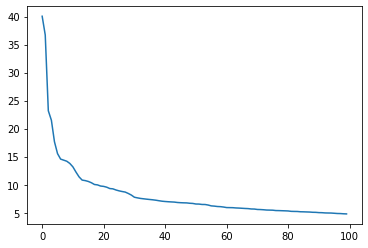

In [9]:
added_svd_in_articles(articles)

In [7]:
#DASH

In [34]:
server = flask.Flask('app')

app = dash.Dash('app', server = server)
app.css.config.serve_locally = True
app.scripts.config.serve_locally = True

app.layout = html.Main([
     html.Link(
        rel='stylesheet',
        href='/static/index.css'
    ),
    html.Center([
        html.Img(src="/static/foogle.png", width="20%", height="5%", id="googleimg"),
        html.Div([
            html.Div([
                html.Span([
                    dcc.Input(name="search", id='input-on-submit', type="text", placeholder="O que gostava de saber?"),
                ], id="inputspan"),
            ], id="maindiv")
        ]),
        html.Section([
            html.Div([
                html.Button('Pesquisa Foogle', id='search-value', n_clicks=0),
            ]),
            html.Div([
                html.Button('Estou com sorte', id='lucky-value', n_clicks=0),
            ]),
        ]),
        html.Br(),
        html.Br(),
        html.Br(),
        html.Br(),
        html.Br(),
        html.Div([
            
        ], id='container-button-basic'),
    ]),   
])

@app.callback(
    Output('container-button-basic', 'children'),
    Input('search-value', 'n_clicks'),
    State('input-on-submit', 'value')
)
def update_output(n_clicks, value):
    
    articles_result = search_with_dash(value, articles)
    #output = ''
    result = []
    for key, value in articles_result:
        #value = item[1]
        #output = output + f'{value["article"]["title"]} - {value["article"]["date_article"]}  {value["article"]["body"][:50]}...'
        result.append(html.Div([
            html.P(f'{value["article"]["title"]} - {value["article"]["date_article"]}'),
            html.P(f'{value["article"]["body"][:50]}'),
            html.Br()
        ]))
    return result

@app.server.route('/static/<path:path>')
def static_file(path):
    static_folder = os.path.join(os.getcwd(), 'static')
    return send_from_directory(static_folder, path)


if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [26/May/2022 18:02:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2022 18:02:35] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2022 18:02:35] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2022 18:02:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2022 18:02:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2022 18:02:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2022 18:42:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2022 18:48:36] "POST /_dash-update-component HTTP/1.1" 200 -


# Usando Spacy/Word2Vec

In [6]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'tagger', 'textcat'])

In [8]:
def tokenizar_com_spacy(texto):
    doc = nlp(texto)
    tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha:
            tokens.append(token.text.lower())
    return tokens

def juntar_vetores_por_soma(palavras, modelo):
    vetor_final = np.zeros((1,600))
    for palavra in palavras:
        try:
            vetor_final += modelo.get_vector(palavra)
        except KeyError:
            pass
    return vetor_final

In [12]:
articles_para_tratamento = (value['body'].lower() for item, value in articles.items())
articles_tratados = [tokenizar_com_spacy(doc) for doc in nlp.pipe(articles_para_tratamento, batch_size=1000, n_process=-1)]
dataframe_artigos_tratados = pd.DataFrame({"artigos": articles_tratados})
dataframe_artigos_tratados.head()

/Users/fagnercandido/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/Users/fagnercandido/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/Users/fagnercandido/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler

,artigos
0,"[inco, ltd, said, expect, earlier, reported, r..."
1,"[mason, benson, president, chief, operating, o..."
2,"[discovery, complicate, search, aids, vaccine,..."
3,"[doctors, centers, disease, control, atlanta, ..."
4,"[economic, data, week, key, determining, inter..."


In [13]:
lista_de_lista_de_tokens = [artigo for artigo in dataframe_artigos_tratados.artigos]

modelo_skipgram = Word2Vec(sg = 1,
                      window = 5,
                      min_count = 5,
                      alpha = 0.03,
                      min_alpha = 0.007)
modelo_skipgram.build_vocab(lista_de_lista_de_tokens, progress_per=5000)

modelo_skipgram.train(lista_de_lista_de_tokens, 
                     total_examples=modelo_skipgram.corpus_count,
                     epochs = 30)

(38028049, 43562460)

In [20]:
modelo_skipgram.wv.most_similar('journal')

[('medicine', 0.6029475927352905),
 ('published', 0.5571476817131042),
 ('editorial', 0.544950544834137),
 ('jacksons', 0.4870747923851013),
 ('alexanders', 0.4798334240913391),
 ('findings', 0.4683205783367157),
 ('keizai', 0.46573489904403687),
 ('article', 0.4626763164997101),
 ('newspaper', 0.45614340901374817),
 ('deny', 0.4538005292415619)]

Process Process-5:
Process Process-3:
Process Process-7:
Process Process-8:
Process Process-6:
Process Process-1:
Process Process-4:
Process Process-2:
Traceback (most recent call last):
  File "/Users/fagnercandido/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/fagnercandido/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/fagnercandido/opt/anaconda3/lib/python3.9/site-packages/spacy/language.py", line 2219, in _apply_pipes
    sender.send(byte_docs + padding)  # type: ignore[operator]
  File "/Users/fagnercandido/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 211, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/fagnercandido/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 410, in _send_bytes
    self._send(buf)
  File "/Users/fagnercandido/opt/anaconda3/lib/python3.9/multiproces